# Investigation of SEDs of ZFourge Templates in UVJ Colour Space
This particular code will be used to investigate the ZFOURGE galaxies using some of michael's code to transform ZFOURGE photometry into SEDs. The SEDs will then be plotted in UVJ colour space to investigate the distribution of the ZFOURGE galaxies in this space. This code is intended to be used to pick a few galaxies in each reigon of the UVJ space, which will then be investigated in further detail.

In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns
import os
from astropy.io import fits
import random
from adjustText import adjust_text  # Import adjust_text from adjustText library


In [2]:
def read_zfourge_data(fieldname, folderpath): # Define a function to read in zfourge data, this will be added to the helper package later
    # Dictionary to read from
    zfourge_fields = {
    'CDFS': ['zf_cdfs.fits', 'zf_cdfs_rest.fits', 'zf_cdfs_eazy.fits', 'zf_cdfs_sfr.fits'],
    'COSMOS': ['zf_cosmos.fits', 'zf_cosmos_rest.fits', 'zf_cosmos_eazy.fits', 'zf_cosmos_sfr.fits'],
    'UDS': ['zf_uds.fits', 'zf_uds_rest.fits', 'zf_uds_eazy.fits', 'zf_uds_sfr.fits'],
}
    
    folder = folderpath
    
    # Construct file paths using os.path.join() to make it platform-independent
    catalog_file = os.path.join(folder, zfourge_fields[fieldname][0])
    rest_file = os.path.join(folder, zfourge_fields[fieldname][1])
    eazy_file = os.path.join(folder, zfourge_fields[fieldname][2])
    sfr_file = os.path.join(folder, zfourge_fields[fieldname][3])
    
    # Open the fits files
    catalog_fits = fits.open(catalog_file)
    rest_fits = fits.open(rest_file)
    sfr_fits = fits.open(sfr_file)
    
    # Read the files into DataFrames
    df = pd.DataFrame(np.array(catalog_fits[1].data).byteswap().newbyteorder()) 
    rest_df = pd.DataFrame(np.array(rest_fits[1].data).byteswap().newbyteorder())
    eazy_df = pd.DataFrame(np.array(fits.open(eazy_file)[1].data).byteswap().newbyteorder())
    sfr_df = pd.DataFrame(np.array(sfr_fits[1].data).byteswap().newbyteorder())
    
    
    # Rename the Seq column to id for consistency
    df.rename(columns={'Seq':'id'}, inplace=True)
    rest_df.rename(columns={'Seq':'id', 'FU':'U', 'e_FU':'eU', 'FV':'V', 'e_FV':'eV', 'FJ':'J','e_FJ':'eJ'}, inplace=True)
    eazy_df.rename(columns={'Seq':'id'}, inplace=True)
    sfr_df.rename(columns={'Seq':'id'}, inplace=True)
    
    
    # We now merge the two dataframes into one dataframe, adding a suffix _rest if columns clash
    #df = pd.merge(df, rest_df, on='id', suffixes=('', '_rest'))
    
    # we now merge rest and df into one
    #df = pd.concat([df, rest_df], axis=1)
    df = pd.merge(df, rest_df[['id', 'U', 'eU', 'V', 'eV', 'J','eJ']], on='id', suffixes=('_original', '_rest'))
    df = pd.merge(df, eazy_df[['id', 'zpk']], on='id', suffixes=('', '_eazy'))
    df = pd.merge(df, sfr_df[['id', 'lssfr', 'lmass']], on='id', suffixes=('', '_sfr'))
    
    
    # Create a new column to mark the field that this data is from
    df['field'] = fieldname + "_"
    
    # In this scenario we don't need to append which field it's from
    fieldname = ""
    
    # rename the number in the id column to be prefixed by the fieldname, this is to avoid confusion when merging dataframes
    df['id'] = fieldname + df['id'].astype(str)
    
    # return the created dataframe
    return df

In [3]:
zfourge_path = 'datasets/zfourge/'

# As we are only working with the ZFOURGE Survey, we will only read in the CDFS data
df = read_zfourge_data('CDFS', zfourge_path)

In [4]:
# Filter the data as necessay
# flux filtering, set a sigma value for the flux error ratio
sigma = 5

# optionally we can filter the data into fields
#field = 'CDFS'
#df = df[df['field'] == field].copy()

# filter for uvj colours, making sure that there isn't a flux below 0
df = df[(df['U'] > 0) & (df['V'] > 0) & (df['J'] > 0) & (df['eU'] > 0) & (df['eV'] > 0) & (df['eJ'] > 0) & (df['Use']==1)].copy()

# we also need to filter by the redshift, Z-fourge only has reliable accuracy for redshifts between 0.2 and 3.2 ~ potentially up to a redshift of 4
# As my project will be investigating redshifts of galaxies where z-0.5~2 we should instead use this range
min_redshift = 0.2
max_redshift = 2

df = df[(df['zpk'] > min_redshift) & (df['zpk'] < max_redshift)].copy()



# Propogate errors from each of the fluxes to the UVJ diagram to a ratio of sigma

df = df[(df['U'] >= sigma * df['eU']) & (df['V'] >= sigma * df['eV']) & (df['J'] >= sigma * df['eJ'])].copy()

In [5]:
# We want to define a function to convert flux to absolute magnitude
def flux_to_mag(flux):
    ab_f = 25 - 2.5*np.log10(flux)
    return ab_f

In [6]:

# Create new columns for the magnitudes of each of the filters
df.loc[:, 'mag_U'] = flux_to_mag(df['U'])
df.loc[:, 'mag_V'] = flux_to_mag(df['V'])
df.loc[:, 'mag_J'] = flux_to_mag(df['J'])

# Likewise also create new columns of the converted errors to magnitudes
df.loc[:, 'e_mag_U'] = flux_to_mag(df['eU'])
df.loc[:, 'e_mag_V'] = flux_to_mag(df['eV'])
df.loc[:, 'e_mag_J'] = flux_to_mag(df['eJ'])

Now that we have our data filtered and cleaned, we can plot the UVJ diagram. 
The aim of this investigation is to choose a good selection of galaxies of which
the UVJ colours are indicative of quiscents, star-forming, and intermeidates.
Preferably with no AGN contamination.
and preferbably that are not chosen with particular bias
We can remove confirmed (by xray) AGN from the sample,
by way of michael's AGN candidates and also create functions to 
Explore different selection methods (using random choice, or a statistical selection method)

Importantly, confirm these selections with the ZFOURGE website and see if they have been catalogued in an astronomical database.

In [7]:
def categorise_uvj(df):
    id = df['id']
    x = df['mag_V'] - df['mag_J']
    y = df['mag_U'] - df['mag_V']

    # Plot the UVJ diagram
    plt.figure(figsize=(10, 10))

    xmax = 2.5
    ymax = 2.5
    xmin = -0.5
    ymin = 0

    # Set the plotting limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # Define the points for a quiescent galaxy selection
    x_points = [-0.5, 0.85, 1.6, 1.6]
    y_points = [1.3, 1.3, 1.95, 2.5]

    # Plot the points
    plt.plot(x_points, y_points, linestyle='-')

    # Interpolate the y-value at x=1.2
    x_target = 1.2
    y_target = np.interp(x_target, x_points, y_points)

    # Plot the interpolated point, this separates everything on the right as dusty galaxies,
    # and everything on the left as star-forming galaxies
    plt.plot([x_target, x_target], [0, y_target], linestyle='--')

    quiescent_x = [-0.5, 0.85, 1.6, 1.6, xmin, xmin]
    quiescent_y = [1.3, 1.3, 1.95, 2.5, ymax, 1.3]
    # We want to make a wedge selection for the Quiescent Selection of Galaxies
    points = np.column_stack([x, y])
    verts = np.array([quiescent_x, quiescent_y]).T
    path = mpath.Path(verts)
    
    
    # Define the path for point selection
    #selected_path = mpath.Path([(2, 3), (6, 4), (8, 2), (2, 1), (2, 3)])  # Example path, replace with your own

    # Use path.contains_points to get a boolean array
    points_inside_selection = path.contains_points(np.column_stack([x, y]))
    
    
    
    dusty_condition = (points[:, 0] > x_target) & (~points_inside_selection)
    star_forming_condition = (points[:, 0] < x_target) & (~points_inside_selection)
    
    

    # Filter the DataFrame using the boolean array
    selected_df = df[points_inside_selection] # For quiescent, clean later
    
    
    # Mark dusty, and star-forming galaxies
    df.loc[dusty_condition, 'GalaxyType'] = 2
    df.loc[star_forming_condition, 'GalaxyType'] = 1
    
    
    
    
    print(selected_df)
    #print(unselected_df)
    
    # Now we can easily select the quiescent galaxies and set the galaxy type to quiescent - 0 or starforming 1.
    print(selected_df)
    selected_ids = selected_df['id']
    df.loc[df['id'].isin(selected_ids), 'GalaxyType'] = 0 # This is what makes the selection happen
    
    
    
    # Try do the same for the unselected galaxies, noting that the unselected galaxies with x and y > 1.2 are dusty galaxies, and the rest are star-forming galaxies
    #unselected_ids = unselected_df['id']
    
    
    
    
    # Sort the quiescent and non-quiescent galaxies
    quiescent_points = points[path.contains_points(points)]
    # Find the points from here to categorise dusty, and star-forming galaxies
    non_quiescent_points = points[~path.contains_points(points)]
    dusty_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] > x_target]
    star_forming_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] < x_target]
    
    
    #print(non_quiescent_points[0][0])
    
    #print(y)
    # Plot the selected points
    #plt.scatter(x, y, s=3, alpha=0.5, label='Not Quiescent Selection')
    plt.scatter(quiescent_points[:, 0], quiescent_points[:, 1], c='r', s=3, alpha=0.5, label='Quiescent Selection')
    plt.scatter(dusty_galaxies_points[:, 0], dusty_galaxies_points[:, 1], c='g', s=3, alpha=0.5, label='Dusty Galaxies')
    plt.scatter(star_forming_galaxies_points[:, 0], star_forming_galaxies_points[:, 1], c='b', s=3, alpha=0.5, label='Star Forming Galaxies')

    plt.xlabel('Restframe V-J [Mag]')
    plt.ylabel('Restframe U-V [Mag]')
    plt.title('UVJ Diagram for the CDFS field')
    plt.legend()
    plt.show()
    return df

       recno     id      xpos      ypos    RAJ2000    DEJ2000  SE  isoArea  \
6438    6426   6426  4655.385  2324.571  53.072933 -27.878326   0    114.0   
7259    7234   7234  4553.939  2541.882  53.077717 -27.869274   3    426.0   
7482    7457   7457  4774.748  2522.375  53.067310 -27.870083   3     73.0   
7570    7544   7544  4338.467  2547.291  53.087875 -27.869051   0     55.0   
8157    8122   8122  3746.897  2689.073  53.115757 -27.863148   0    172.0   
...      ...    ...       ...       ...        ...        ...  ..      ...   
29938  29880  29880  3846.890  7206.187  53.111065 -27.674934   3    321.0   
29948  30220  30220  4029.372  7352.167  53.102482 -27.668852   3    131.0   
30245  30244  30244  3222.185  7352.918  53.140457 -27.668821   0     66.0   
30542  30540  30540  2669.843  7538.817  53.166439 -27.661070   0    129.0   
30718  30718  30718  3080.672  7526.409  53.147110 -27.661591   3    212.0   

          FKsap  e_FKsap  ...     zpk  lssfr  lmass  field     

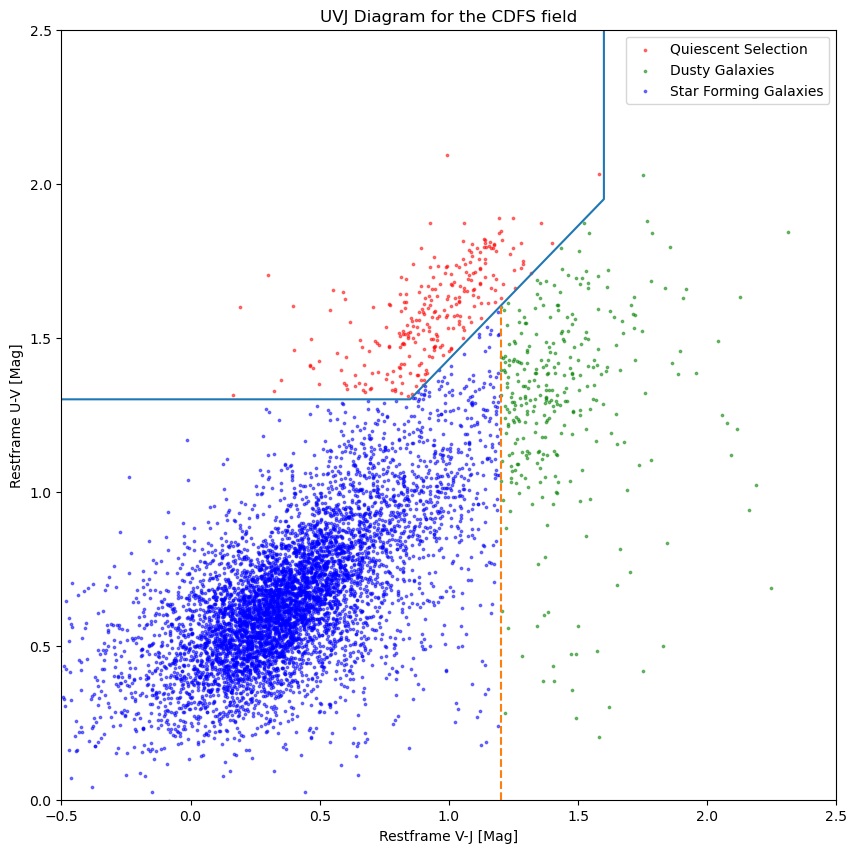

In [8]:
df = categorise_uvj(df)

In [9]:
df['GalaxyType'] = df['GalaxyType'].astype('category')

In [10]:
# 0 - Quiescent, 1 - Star Forming, 2 - Dusty
df['GalaxyType'].value_counts()

1.0    6253
2.0     317
0.0     264
Name: GalaxyType, dtype: int64

In [ ]:
# At this point we have our full selection, export the ID's and redshifts
selected_uvj_ids = df['id']
selected_uvj_redshifts = df['zpk']
selected_uvj_uv_pos = df['mag_U'] - df['mag_V']
selected_uvj_vj_pos = df['mag_V'] - df['mag_J']


# combine these into a single dataframe
selected_uvj_df_ids = pd.DataFrame({'id': selected_uvj_ids, 'zpk': selected_uvj_redshifts, 'uv' : selected_uvj_uv_pos, 'vj' : selected_uvj_vj_pos})


# save the selection to a csv file
save_csv_with_numbered_name(selected_uvj_df_ids, 'datasets/zfourge/GalaxySelectionOutputs', 'full_cdfs_ids.csv')

Now that we have categorised the galaxies, we can investigate the SEDs of the galaxies in each category.

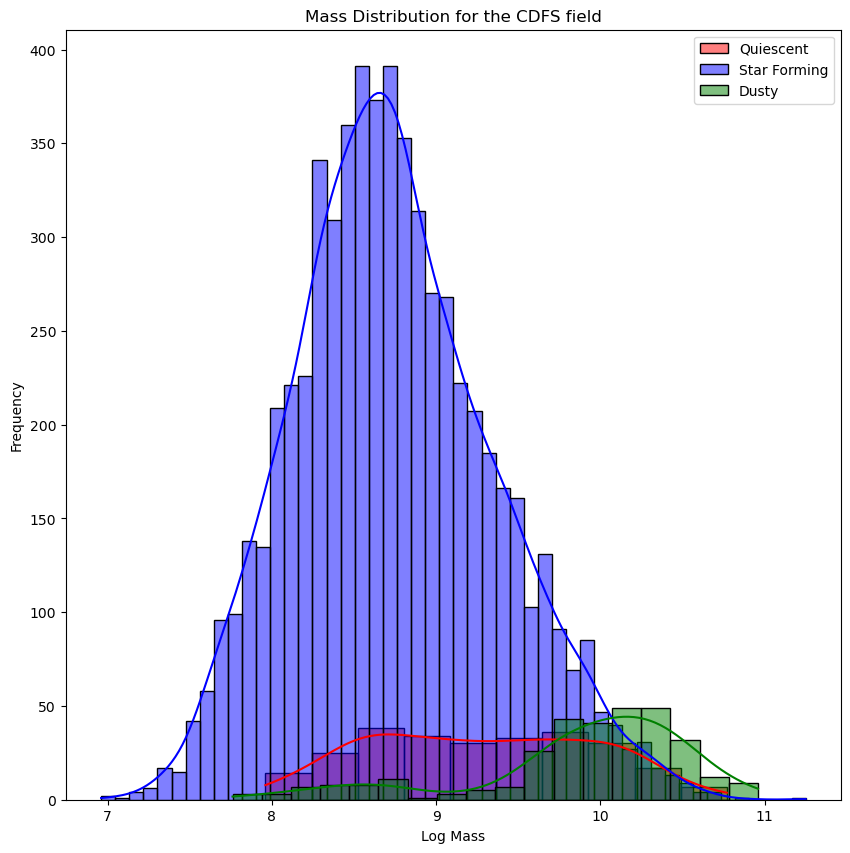

In [11]:
# We are now going to plot distributions for each of the populations of their mass
# with a seperate distribution for each of the populations

# First an overall plot
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 0]['lmass'], kde=True
                , color='r', label='Quiescent')
sns.histplot(df[df['GalaxyType'] == 1]['lmass'], kde=True
                , color='b', label='Star Forming')
sns.histplot(df[df['GalaxyType'] == 2]['lmass'], kde=True
                , color='g', label='Dusty')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()



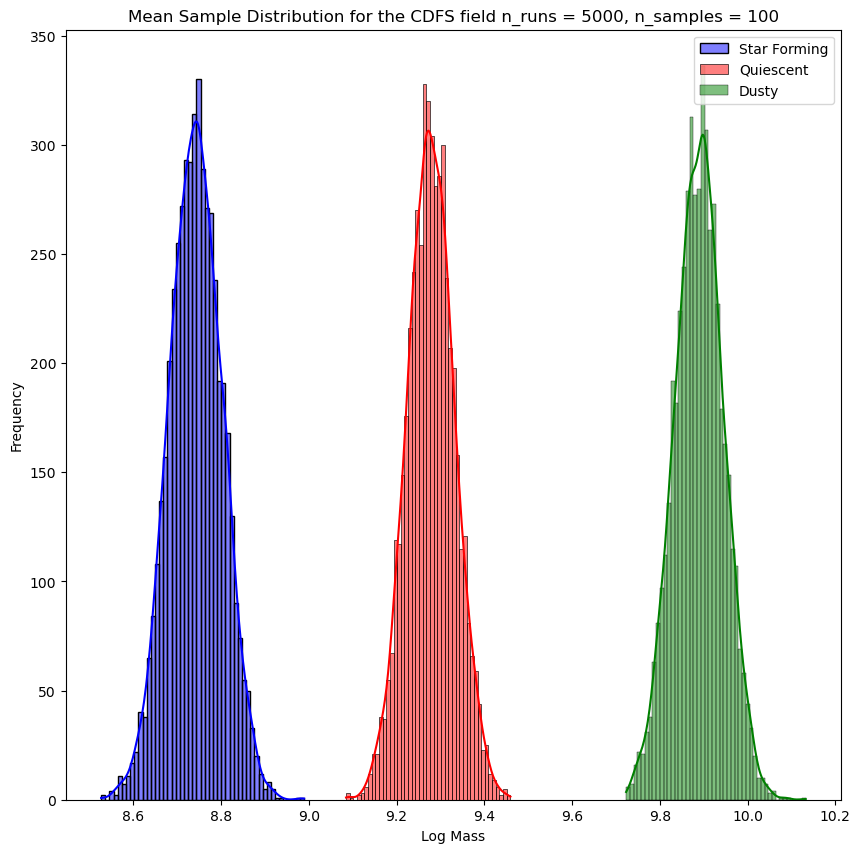

In [12]:
# For each of the regions, we would like to sample 10 galaxies from each of the regions
# Calculate the mean for that region, and do this for 500 runs, 
# then plot the distribution of the means for each of the regions (the sample, not the population)

starforming_df = df[df['GalaxyType'] == 1].copy()
quiescent_df = df[df['GalaxyType'] == 0].copy()
dusty_df = df[df['GalaxyType'] == 2].copy()

# means
starforming_means = []
quiescent_means = []
dusty_means =[]

num_trials = 5000 # number of runs 
sample_size = 100
seed = None
for i in range(num_trials):
    # sample the data
    starforming_sample = starforming_df.sample(sample_size, random_state=seed)
    quiescent_sample = quiescent_df.sample(sample_size, random_state=seed)
    dusty_sample = dusty_df.sample(sample_size, random_state=seed)
    
    # calculate the mean
    starforming_mean = starforming_sample['lmass'].mean()
    quiescent_mean = quiescent_sample['lmass'].mean()
    dusty_mean = dusty_sample['lmass'].mean()
    
    # append the mean to the list
    starforming_means.append(starforming_mean)
    quiescent_means.append(quiescent_mean)
    dusty_means.append(dusty_mean)
    
# Plot the distributions of the means
plt.figure(figsize=(10, 10))
sns.histplot(starforming_means, kde=True
                , color='b', label='Star Forming')
sns.histplot(quiescent_means, kde=True
                , color='r', label='Quiescent')
sns.histplot(dusty_means, kde=True
                , color='g', label='Dusty')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mean Sample Distribution for the CDFS field n_runs = '+str(num_trials)+ ', n_samples = ' + str(sample_size))
plt.legend()
plt.show()





In [13]:
# Using this information we can create constrains for when we do a random selection on the population


# using the above information. get the mean and standard deviation for each of the populations
starforming_mean = np.mean(starforming_means)
starforming_std = np.std(starforming_means)

quiescent_mean = np.mean(quiescent_means)
quiescent_std = np.std(quiescent_means)

dusty_mean = np.mean(dusty_means)
dusty_std = np.std(dusty_means)


# Print the results

# Below we have information about the mean and standard deviation of the sample distribution of the mean

print("Statistics for the Sample Distribution of the Mean for the CDFS field:")
print("----------------------------------------------------------------------")
# for each population
print("Starforming Mean: ", starforming_mean, " Starforming Std: ", starforming_std)
print("Quiescent Mean: ", quiescent_mean, " Quiescent Std: ", quiescent_std)
print("Dusty Mean: ", dusty_mean, " Dusty Std: ", dusty_std)

# We may want to make a selection within 3 standard deviations of the mean for each of the populations


# get our mass ranges for each of the populations (these are mass ranges for the sample distribution of the mean)
starforming_lower = starforming_mean - 3*starforming_std
starforming_upper = starforming_mean + 3*starforming_std

quiescent_lower = quiescent_mean - 3*quiescent_std
quiescent_upper = quiescent_mean + 3*quiescent_std

dusty_lower = dusty_mean - 3*dusty_std
dusty_upper = dusty_mean + 3*dusty_std

# we can try use them in our selection


Statistics for the Sample Distribution of the Mean for the CDFS field:
----------------------------------------------------------------------
Starforming Mean:  8.741758  Starforming Std:  0.060033694
Quiescent Mean:  9.278173  Quiescent Std:  0.053762157
Dusty Mean:  9.889266  Dusty Std:  0.055674907


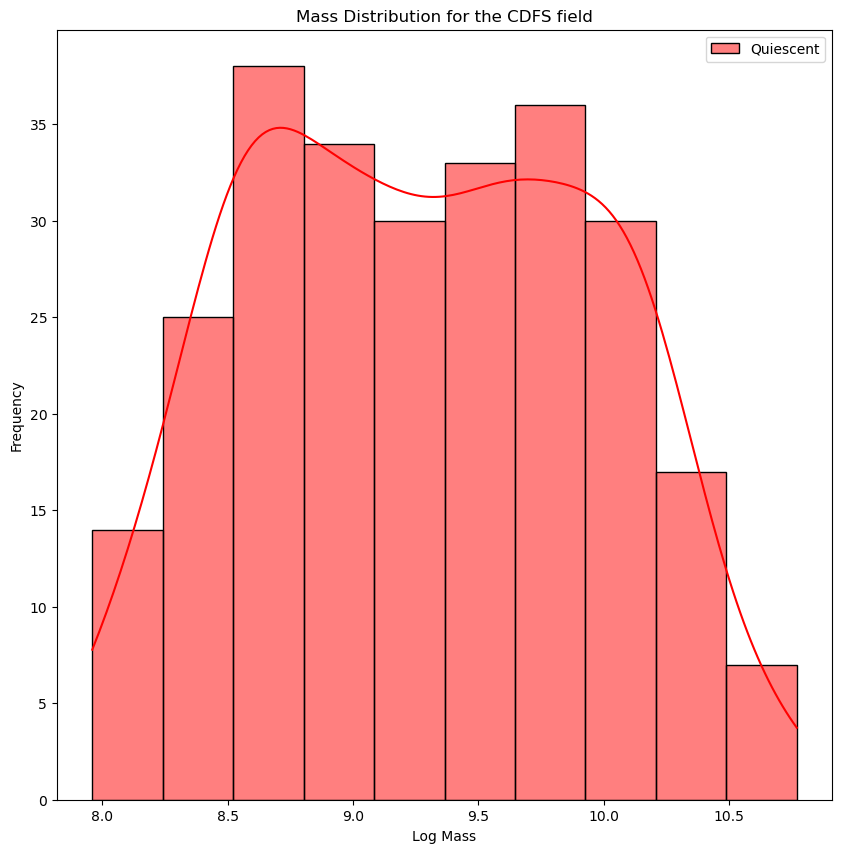

In [14]:
# Quiescent
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 0]['lmass'], kde=True
                , color='r', label='Quiescent')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()

# Mean and Standard Deviation for the Quiescent Galaxies
quiescent_mean = df[df['GalaxyType'] == 0]['lmass'].mean()
quiescent_std = df[df['GalaxyType'] == 0]['lmass'].std()






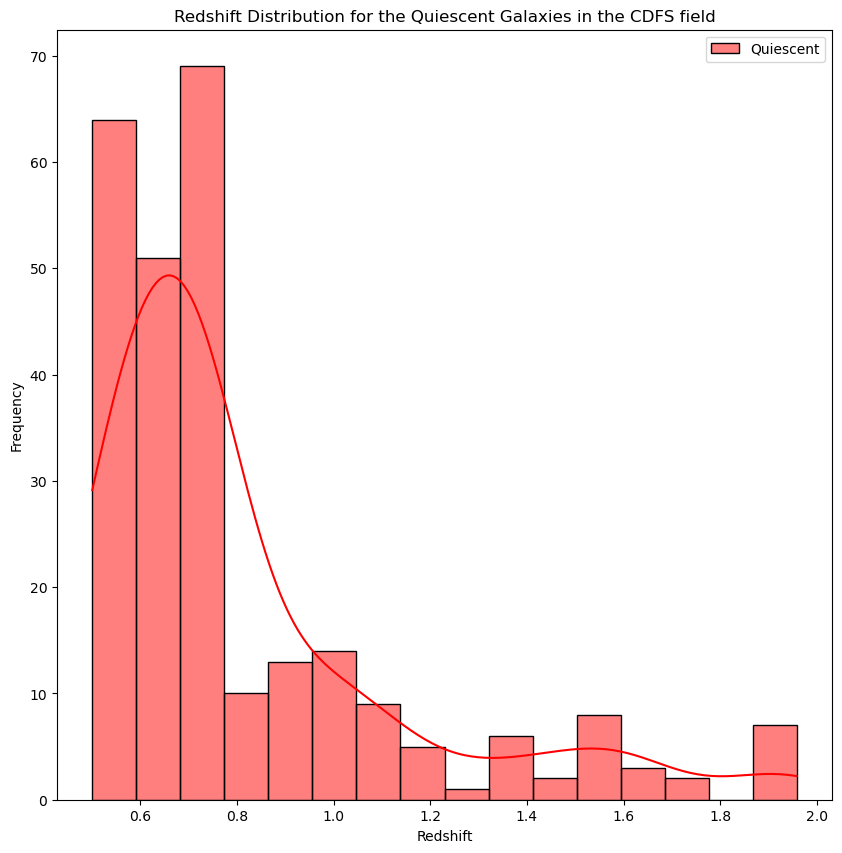

In [15]:
# For these red quiescent galaxies we can attempt to explore the distribution in a touch more detail
# As we see something resembling biomodality we can explore this ina  touch more detail
# Explore the redshifts of these quiescent fractions
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 0]['zpk'], kde=True
                , color='r', label='Quiescent')
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('Redshift Distribution for the Quiescent Galaxies in the CDFS field')
plt.legend()
plt.show()



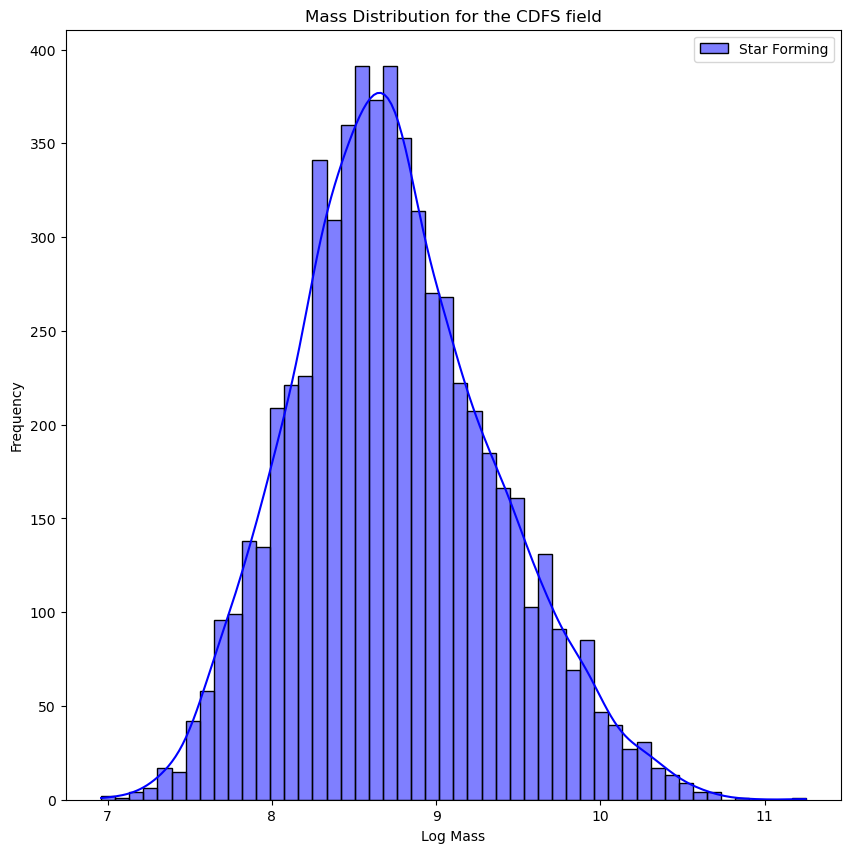

In [16]:
#Star-forming
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 1]['lmass'], kde=True
                , color='b', label='Star Forming')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()

# Mean and Standard Deviation for the Star Forming Galaxies
star_forming_mean = df[df['GalaxyType'] == 1]['lmass'].mean()
star_forming_std = df[df['GalaxyType'] == 1]['lmass'].std()


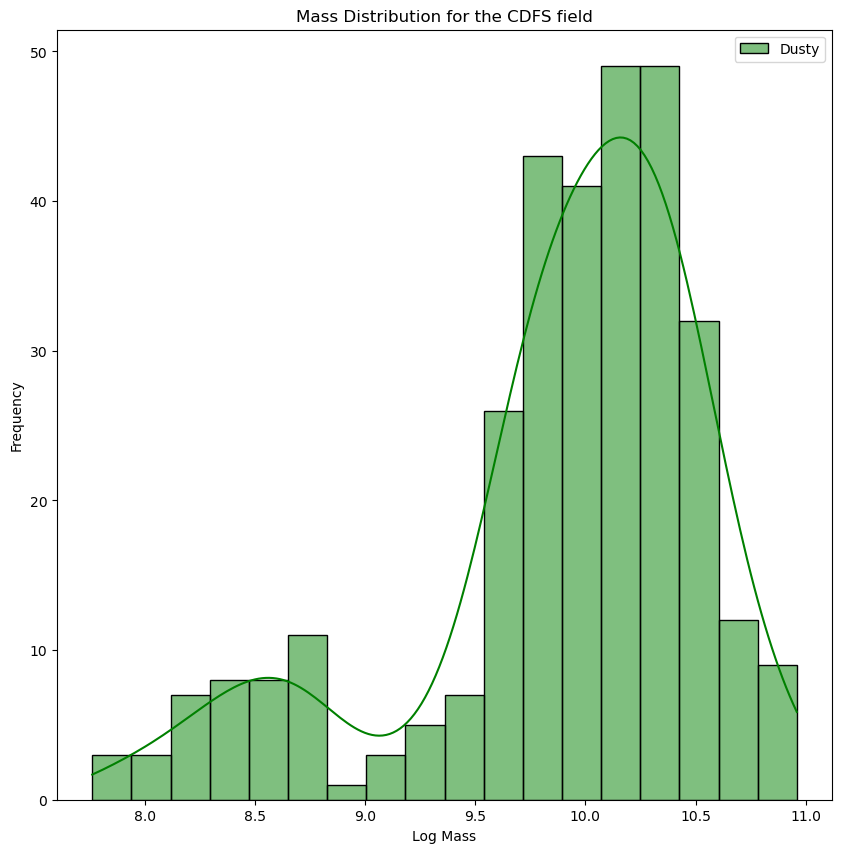

In [17]:
# Dusty
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 2]['lmass'], kde=True
                , color='g', label='Dusty')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()

# Mean and Standard Deviation for the Dusty Galaxies
dusty_mean = df[df['GalaxyType'] == 2]['lmass'].mean()
dusty_std = df[df['GalaxyType'] == 2]['lmass'].std()

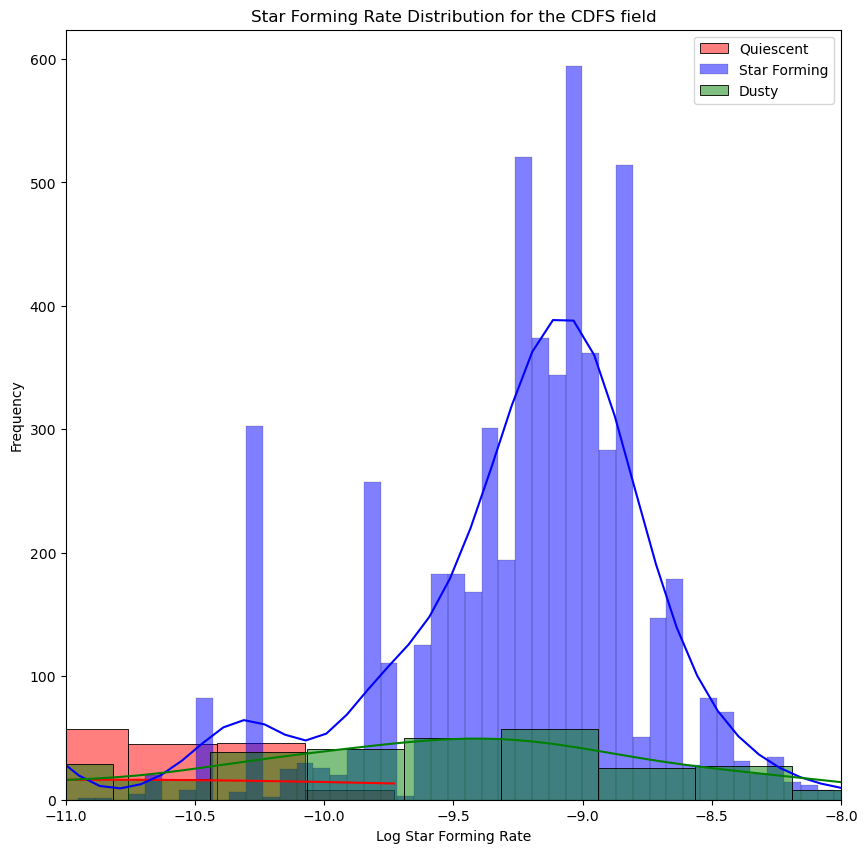

In [18]:
# We can also explore distributions of star forming rate
# First an overall plot - This shows us the wild difference in the quiescent, star-forming and dusty populations
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 0]['lssfr'], kde=True
                , color='r', label='Quiescent')
sns.histplot(df[df['GalaxyType'] == 1]['lssfr'], kde=True
                , color='b', label='Star Forming')
sns.histplot(df[df['GalaxyType'] == 2]['lssfr'], kde=True
                , color='g', label='Dusty')
plt.xlabel('Log Star Forming Rate')
plt.ylabel('Frequency')

plt.xlim([-11, -8])

plt.title('Star Forming Rate Distribution for the CDFS field')
plt.legend()
plt.show()

In [19]:
seed = 42
random.seed(seed)

Now that we have a dataframe that can be used, with information about each of the galaxy types. We can use each of these reigons, selecting a galaxy and returning the ID of that galaxy. We can do this on multiple fronts. 

1. Create a function that given a dataframe, returns the ID of a galaxy in that dataframe, this will
    take in a couple of parameters in the dataframe. I.e the reigon of selection, mass range, redshift range, sfr range, etc
2. Create a random selection function that given a dataframe, returns the ID of a galaxy within that dataframe
    this could call upon the above function to select a galaxy within a reigon, and then return the ID of that galaxy.
3. Create a function that given a dataframe, will return a list of IDs of galaxies within that dataframe, with an appropriate amount of galaxies selected from each reigon. Provide the option to select the number of galaxies from each reigon, or default to some amount if not specified. 

In [20]:
def get_uvj_id(df, reigon, n = 0, mass_limits=None):
    """_summary_

    Args:
        df (_type_): _description_
        reigon (_type_): _description_
        mass_range (list): the min and max mass range of the selection


    Returns:
        _type_: _description_
    """
    # Filter the data based on the reigon
    if reigon == 'Quiescent':
        selected_df = df[df['GalaxyType'] == 0].copy()
    elif reigon == 'Star Forming':
        selected_df = df[df['GalaxyType'] == 1].copy()
    elif reigon == 'Dusty':
        selected_df = df[df['GalaxyType'] == 2].copy()
    else:
        selected_df = df.copy()
    
    # Filter the data based on the mass range
    if mass_limits != None:
            selected_df = selected_df[(selected_df['lmass'] > mass_limits[0]) & (selected_df['lmass'] < mass_limits[1])].copy()
    
    
    
    # Filter the data based on the mass range
    #selected_df = selected_df[(selected_df['lmass'] > mass_range[0]) & (selected_df['lmass'] < mass_range[1])].copy()
    # Randomly select an ID from the dataframe and return the ID

    
    #selected_id = selected_df.sample(n=1, random_state=65489)['id'].values[0]
    
    #given a list of ids
    ids = selected_df['id'].values
    print(ids)
    
    random.seed(42)
    selected_ids = random.sample(list(ids), n)
    
    
    
    print(selected_ids)
    # This is where we want to make a selection on the UVJ space
    return selected_ids


# Function to get a random ID that is not already in the list
#def get_unique_id(df, reigon, id_list, mass_limits=None):
#    while True:
#        random_id = get_uvj_id(df, reigon, mass_limits)
#        if random_id not in id_list:
#            return random_id

In [21]:
# Extend this idea to select multiple id's from each reigon, putting them into dataframe
# We should be able to run this multiple times, getting a different sample every time if needed.
def get_uvj_ids(df, n, sf_mass_limits=None, qsct_mass_limits=None, dust_mass_limits=None):
    """_summary_

    Args:
        df (_type_): _description_
        reigon (_type_): _description_
        n (int): the number of selections for each reigon


    Returns:
        _type_: a for each of the reigons, containing the selected ID's in each of those reigons.
    """
    
    
    star_forming_ids=[]
    quiescent_ids=[]
    dusty_ids=[]
    
    
    # Check to see if n is greater then the max number of the smallest array
    if n > min([df['GalaxyType'].value_counts()[0], df['GalaxyType'].value_counts()[1], df['GalaxyType'].value_counts()[2]]):
        print('n is greater than the smallest number of galaxies in a reigon')
        # If this is the case, we should set n to the smallest number of galaxies in a reigon
        n = min([df['GalaxyType'].value_counts()[0], df['GalaxyType'].value_counts()[1], df['GalaxyType'].value_counts()[2]])
    
        # Generate n random IDs for each condition
    
    sf_id = get_uvj_id(df, 'Star Forming', n, sf_mass_limits)
    qsct_id = get_uvj_id(df, 'Quiescent', n, qsct_mass_limits)
    dust_id = get_uvj_id(df, 'Dusty', n, dust_mass_limits)

    # Append unique IDs to the lists
    star_forming_ids = sf_id
    quiescent_ids= qsct_id
    dusty_ids = dust_id

    
    selected_ids = pd.DataFrame({'Star-forming ID': star_forming_ids, 'Quiescent ID': quiescent_ids, 'Dusty ID': dusty_ids})
    
    # using the original input dataframe, create a dataframe that is a subset of the original dataframe,
    # containing information relevant to the dataframe from each id list
    selected_df = df[df['id'].isin(selected_ids.values.flatten())] 
    
    # This is where we want to make a selection on the UVJ space
    return selected_ids, selected_df


The upper an lower limits for reproducability can be generated from these numbers, otherwise
for more randomness, use the starting numbers

Starforming Mean:  8.743062869644165  Starforming Std:  0.06031761153109876

Quiescent Mean:  9.276950852203369  Quiescent Std:  0.0533551243884157

Dusty Mean:  9.888966116333007  Dusty Std:  0.055130241549101094

In [22]:
# Get the selected IDs - no mass limits
#selected_ids, selected_df = get_uvj_ids(df, 20)

# sf mean

# sf std


if seed == 42:
    starforming_lower = 8.743062869644165 - 3*0.06031761153109876
    starforming_upper = 8.743062869644165 + 3*0.06031761153109876

    quiescent_lower = 9.276950852203369 - 3*0.0533551243884157
    quiescent_upper = 9.276950852203369 + 3*0.0533551243884157

    dusty_lower = 9.888966116333007 - 3*0.055130241549101094
    dusty_upper = 9.888966116333007 + 3*0.055130241549101094

# number of galaxies to select in each reigon

num_galaxies_per_reigon = 20

# Get the selected IDs - with mass limits
selected_ids, selected_df = get_uvj_ids(df, num_galaxies_per_reigon, sf_mass_limits=[starforming_lower, starforming_upper], qsct_mass_limits=[quiescent_lower, quiescent_upper], dust_mass_limits=[dusty_lower, dusty_upper])
#selected_ids, selected_df = get_uvj_ids(df, 1, None, None, None)

['6148' '6237' '6249' ... '30800' '30807' '30906']
['26789', '11731', '8214', '30354', '16360', '15478', '14935', '12659', '30053', '11488', '27838', '30285', '23976', '11020', '25353', '20265', '8827', '8693', '11174', '14761']
['7544' '8122' '11494' '12171' '12382' '13149' '13237' '13592' '15802'
 '15910' '16233' '16251' '16827' '17055' '17166' '17210' '17488' '17560'
 '17762' '18538' '19451' '19539' '19980' '20921' '20975' '21446' '21509'
 '25272' '25946' '26292' '26347' '26828' '28434' '28640' '29251' '29790'
 '30540']
['13592', '8122', '17560', '17210', '17166', '15802', '20921', '12171', '19539', '26347', '29251', '11494', '17762', '17055', '29790', '7544', '21446', '13237', '30540', '17488']
['6964' '8587' '9194' '9705' '11279' '11420' '12014' '12064' '13736'
 '13748' '13751' '13811' '14328' '15136' '15181' '15461' '15858' '15880'
 '15908' '16078' '16367' '16903' '16914' '16957' '17005' '17142' '18643'
 '18695' '18706' '18980' '18999' '19318' '20090' '20334' '21051' '21236'
 '21

In [23]:
# Using the ID's from the above dataframe, we can create a dataframe from the original cdfs dataframe
# that contains all the relevant information


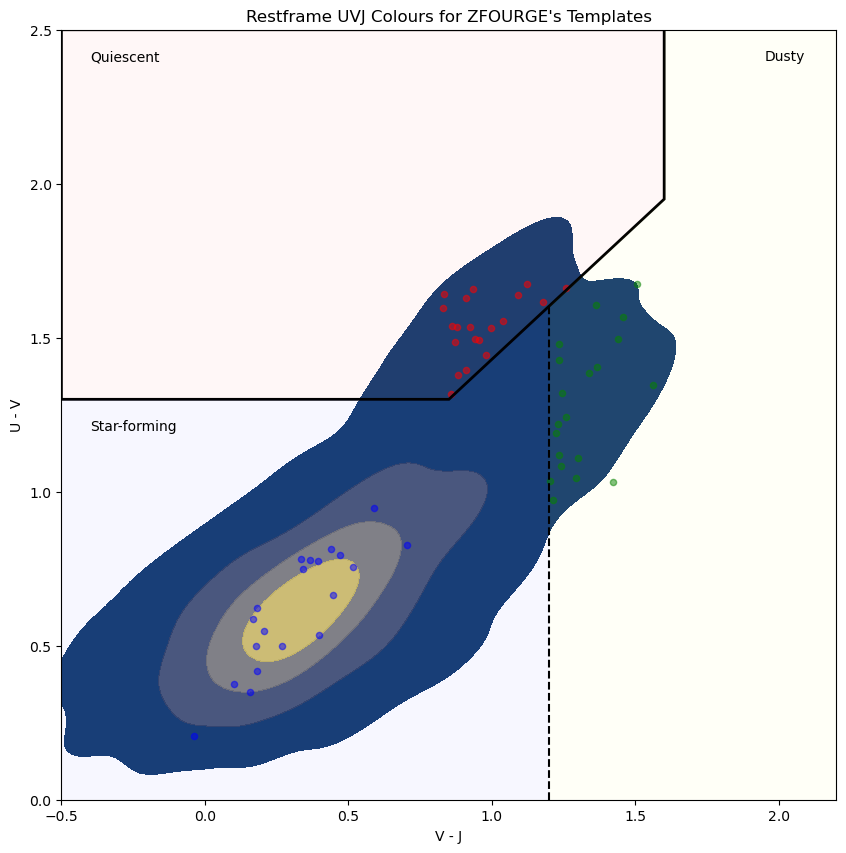

In [24]:
# Now what we can do is plot this data on the UVJ diagram coloured, with the unselected data in grey
# Plot the UVJ diagram


selected_df_sf = selected_df[selected_df['GalaxyType'] == 1]
selected_df_qsct = selected_df[selected_df['GalaxyType'] == 0]
selected_df_dust = selected_df[selected_df['GalaxyType'] == 2]


uv_sf = selected_df_sf['mag_U'] - selected_df_sf['mag_V']
vj_sf = selected_df_sf['mag_V'] - selected_df_sf['mag_J']

uv_qsct = selected_df_qsct['mag_U'] - selected_df_qsct['mag_V']
vj_qsct = selected_df_qsct['mag_V'] - selected_df_qsct['mag_J']

uv_dust = selected_df_dust['mag_U'] - selected_df_dust['mag_V']
vj_dust = selected_df_dust['mag_V'] - selected_df_dust['mag_J']

    



plt.figure(figsize=(10, 10))

# Plot the entire dataset in grey
#plt.scatter(df['mag_V'] - df['mag_J'], df['mag_U'] - df['mag_V'], s=3, alpha=0.1, color='grey', label='Unselected')

# get x and y for the full dataset
uv = df['mag_U'] - df['mag_V'] # Y
vj = df['mag_V'] - df['mag_J'] # X

# seaborn KDE
sns.kdeplot(x=vj, y=uv, fill=True, cmap='cividis', levels=5, alpha=0.9)


# Now each in of the otherss, coloured
plt.scatter(vj_sf, uv_sf, s=20, alpha=0.5, color='blue', label='Star Forming')
plt.scatter(vj_qsct, uv_qsct, s=20, alpha=0.5, color='red', label='Quiescent')
plt.scatter(vj_dust, uv_dust, s=20, alpha=0.5, color='green', label='Dusty')



plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours for ZFOURGE's Templates")
plt.xlim([-0.5,2.2])
plt.axes.line_width = 4
plt.ylim([0,2.5])


    # We can use code to make patch selections on the UVJ diagram, selecting Quiescent, Star-forming, and Dusty Galaxies
    # We use the paths as provided below to make the selections.
path_quiescent = [[-0.5, 1.3],
                    [0.85, 1.3],
                    [1.6, 1.95],
                    [1.6, 2.5],
                    [-0.5, 2.5]]

path_sf = [[-0.5, 0.0],
            [-0.5, 1.3],
            [0.85, 1.3],
            [1.2, 1.60333],
            [1.2, 0.0]]

path_sfd = [[1.2, 0.0],
                [1.2, 1.60333],
                [1.6, 1.95],
                [1.6, 2.5],
                [2.2, 2.5],
                [2.2, 0.0]]

plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03),edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5) 


plt.annotate('Quiescent', (-0.4, 2.4), color='black')
plt.annotate('Star-forming', (-0.4, 1.2), color='black')
plt.annotate('Dusty', (1.95, 2.4), color='black')
plt.show()

       recno     id      xpos      ypos    RAJ2000    DEJ2000  SE  isoArea  \
7570    7544   7544  4338.467  2547.291  53.087875 -27.869051   0     55.0   
8157    8122   8122  3746.897  2689.073  53.115757 -27.863148   0    172.0   
11507  11494  11494  3896.661  3370.405  53.108704 -27.834759   3     67.0   
12198  12171  12171  5073.970  3520.816  53.053234 -27.828476   3    233.0   
13281  13237  13237  4552.608  3700.104  53.077801 -27.821014   3    117.0   
13637  13592  13592  2683.995  3747.007  53.165836 -27.819061   3     35.0   
15914  15802  15802  2634.521  4208.432  53.168156 -27.799835   0     99.0   
17211  17055  17055  5413.311  4452.082  53.037277 -27.789663   2    125.0   
17330  17166  17166  4523.324  4482.839  53.079193 -27.788401   2    116.0   
17376  17210  17210  4409.897  4483.504  53.084538 -27.788376   0     96.0   
17661  17488  17488  1971.210  4517.731  53.199394 -27.786934   0     39.0   
17732  17560  17560  4858.153  4550.959  53.063427 -27.785557   

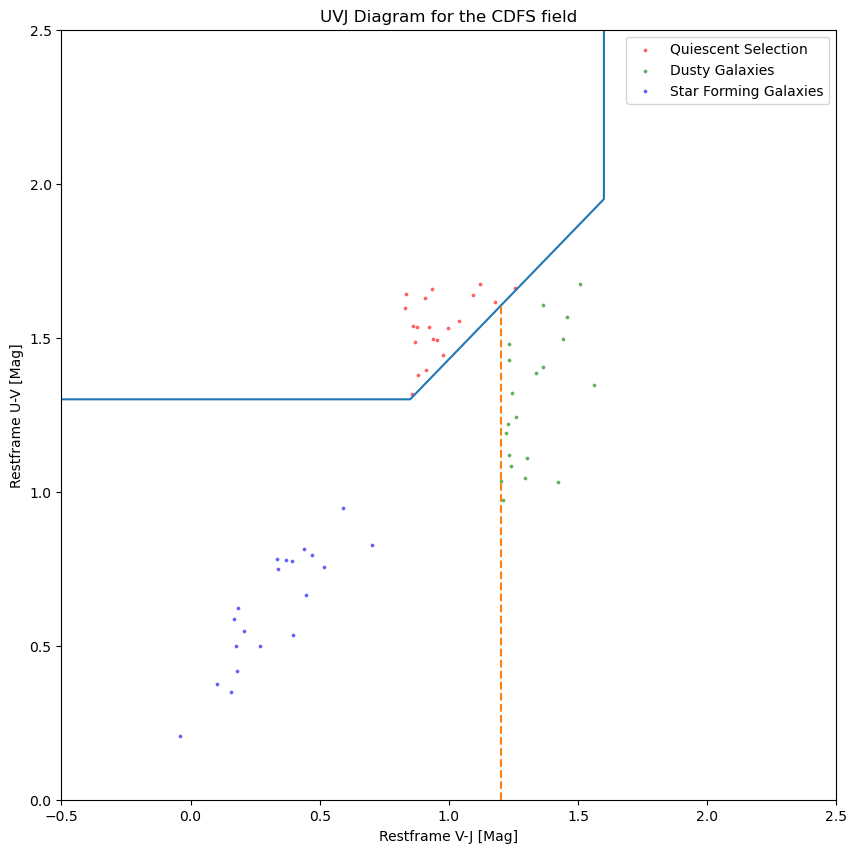

,recno,id,xpos,ypos,RAJ2000,DEJ2000,SE,isoArea,FKsap,e_FKsap,...,lssfr,lmass,field,mag_U,mag_V,mag_J,e_mag_U,e_mag_V,e_mag_J,GalaxyType
7570,7544,7544,4338.467,2547.291,53.087875,-27.869051,0,55.0,0.93743,0.06926,...,-12.28,9.17,CDFS_,27.624173,26.090562,25.213097,29.709245,28.869763,29.771299,0.0
8157,8122,8122,3746.897,2689.073,53.115757,-27.863148,0,172.0,5.23154,0.05406,...,-10.54,9.28,CDFS_,25.746328,24.260967,23.390966,29.259006,29.352575,30.734681,0.0
8247,8214,8214,4156.424,2685.099,53.096455,-27.863312,0,41.0,0.73463,0.06359,...,-9.27,8.79,CDFS_,26.708999,25.934054,25.540034,30.127085,30.041885,29.622342,1.0
8617,8587,8587,4542.331,2839.072,53.078270,-27.856892,3,483.0,27.10114,0.06656,...,-9.93,10.05,CDFS_,24.054246,22.626952,21.394954,27.505623,26.825762,26.508399,2.0
8722,8693,8693,3866.831,2804.641,53.110104,-27.858332,0,117.0,2.36665,0.05182,...,-9.46,8.75,CDFS_,25.777903,24.831467,24.241518,29.479098,30.243943,30.774166,1.0
8858,8827,8827,4175.118,2815.541,53.095577,-27.857876,0,22.0,0.29311,0.06216,...,-9.20,8.84,CDFS_,27.164621,26.617288,26.411938,29.739833,29.820295,31.100000,1.0
9726,9705,9705,4612.138,3053.600,53.074985,-27.847952,3,140.0,2.49768,0.06573,...,-11.17,9.99,CDFS_,26.226960,24.840869,23.502594,28.082935,27.116782,26.812079,2.0
11029,11020,11020,4816.523,3272.352,53.065357,-27.838833,0,25.0,0.40571,0.07074,...,-9.09,8.58,CDFS_,26.958418,26.335417,26.153544,30.523877,30.902046,30.001668,1.0
11179,11174,11174,5064.369,3304.981,53.053680,-27.837469,1,24.0,0.37996,0.07259,...,-9.09,8.60,CDFS_,27.429569,26.681792,26.341679,29.709245,28.949153,30.294452,1.0
11283,11279,11279,4032.974,3336.275,53.102280,-27.836180,3,92.0,3.14299,0.05002,...,-9.22,10.00,CDFS_,26.003450,24.782624,23.553955,29.279114,28.496518,27.940910,2.0


In [25]:
categorise_uvj(selected_df) #ignore outputs as we are only using this to make sure the data is correct in the above plot as below: We can use this to check the data is correct

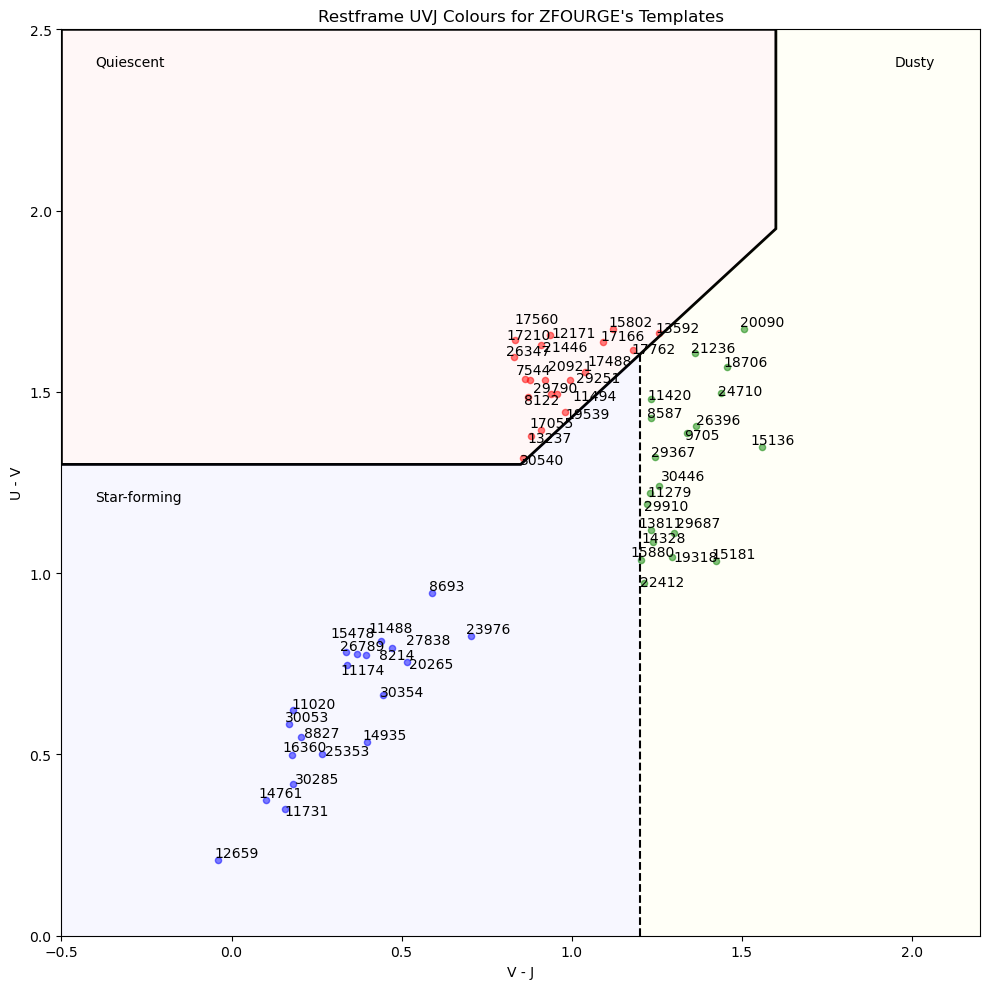

In [26]:
# To check that everything is correct, we can plot the UVJ diagram with the vj, and uv coordinates in brackets next to each UVJ point


selected_df_sf = selected_df[selected_df['GalaxyType'] == 1]
selected_df_qsct = selected_df[selected_df['GalaxyType'] == 0]
selected_df_dust = selected_df[selected_df['GalaxyType'] == 2]


uv_sf = selected_df_sf['mag_U'] - selected_df_sf['mag_V']
vj_sf = selected_df_sf['mag_V'] - selected_df_sf['mag_J']

uv_qsct = selected_df_qsct['mag_U'] - selected_df_qsct['mag_V']
vj_qsct = selected_df_qsct['mag_V'] - selected_df_qsct['mag_J']

uv_dust = selected_df_dust['mag_U'] - selected_df_dust['mag_V']
vj_dust = selected_df_dust['mag_V'] - selected_df_dust['mag_J']

    



plt.figure(figsize=(10, 10))



# Now each in of the otherss, coloured
plt.scatter(vj_sf, uv_sf, s=20, alpha=0.5, color='blue', label='Star Forming')
plt.scatter(vj_qsct, uv_qsct, s=20, alpha=0.5, color='red', label='Quiescent')
plt.scatter(vj_dust, uv_dust, s=20, alpha=0.5, color='green', label='Dusty')

# We would like to add the coordinates to each of the points
# for i in range(len(selected_df)):
#     plt.annotate(f'({selected_df.iloc[i]["mag_V"] - selected_df.iloc[i]["mag_J"]:.2f}, {selected_df.iloc[i]["mag_U"] - selected_df.iloc[i]["mag_V"]:.2f})', (selected_df.iloc[i]["mag_V"] - selected_df.iloc[i]["mag_J"], selected_df.iloc[i]["mag_U"] - selected_df.iloc[i]["mag_V"]))

# Plotting loop to annotate points
annotations = []
for i in range(len(selected_df)):
    x = selected_df.iloc[i]["mag_V"] - selected_df.iloc[i]["mag_J"]
    y = selected_df.iloc[i]["mag_U"] - selected_df.iloc[i]["mag_V"]
    
    # in addition to this we would also like to plot the ID somewhere
    id = selected_df.iloc[i]['id']
    annotations.append(plt.text(x, y,  f'{id}'))
    #f'({x:.2f}, {y:.2f})

# Use adjust_text to automatically adjust text labels to avoid overlap without arrows
adjust_text(annotations)

plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours for ZFOURGE's Templates")
plt.xlim([-0.5,2.2])
plt.axes.line_width = 4
plt.ylim([0,2.5])


    # We can use code to make patch selections on the UVJ diagram, selecting Quiescent, Star-forming, and Dusty Galaxies
    # We use the paths as provided below to make the selections.
path_quiescent = [[-0.5, 1.3],
                    [0.85, 1.3],
                    [1.6, 1.95],
                    [1.6, 2.5],
                    [-0.5, 2.5]]

path_sf = [[-0.5, 0.0],
            [-0.5, 1.3],
            [0.85, 1.3],
            [1.2, 1.60333],
            [1.2, 0.0]]

path_sfd = [[1.2, 0.0],
                [1.2, 1.60333],
                [1.6, 1.95],
                [1.6, 2.5],
                [2.2, 2.5],
                [2.2, 0.0]]

plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03),edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5) 

plt.tight_layout()

plt.annotate('Quiescent', (-0.4, 2.4), color='black')
plt.annotate('Star-forming', (-0.4, 1.2), color='black')
plt.annotate('Dusty', (1.95, 2.4), color='black')
plt.show()

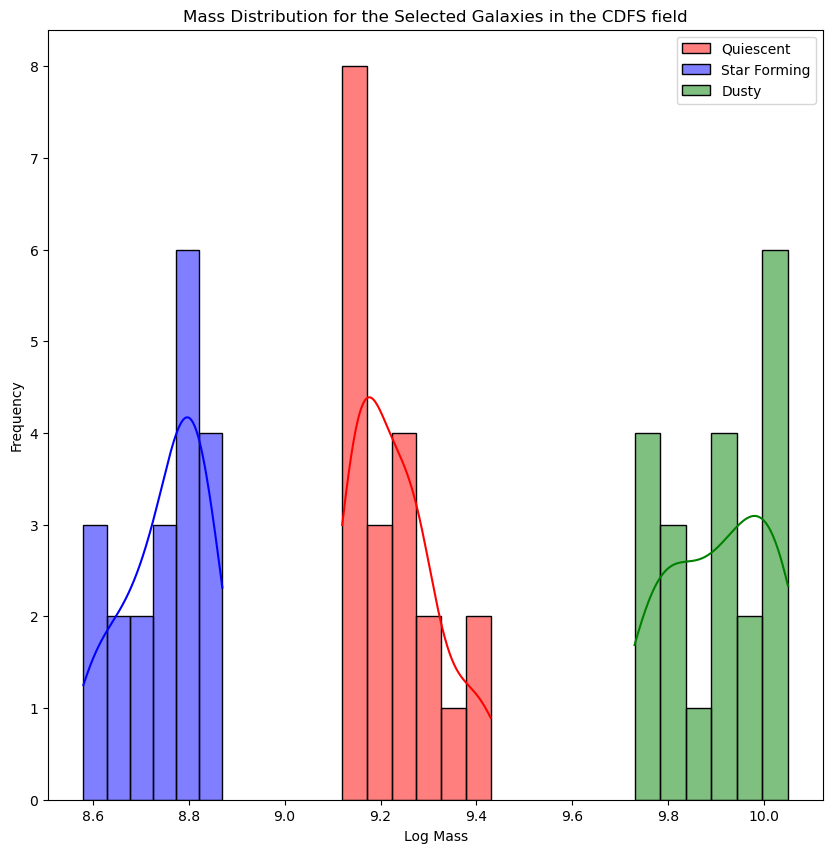

In [27]:
# We would now like to plot the mass distribution for the selected galaxies, seperated by reigon

plt.figure(figsize=(10, 10))
sns.histplot(selected_df[selected_df['GalaxyType'] == 0]['lmass'], kde=True
                , color='r', label='Quiescent')
sns.histplot(selected_df[selected_df['GalaxyType'] == 1]['lmass'], kde=True
                , color='b', label='Star Forming')
sns.histplot(selected_df[selected_df['GalaxyType'] == 2]['lmass'], kde=True
                , color='g', label='Dusty')

plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the Selected Galaxies in the CDFS field')
plt.legend()
plt.show()


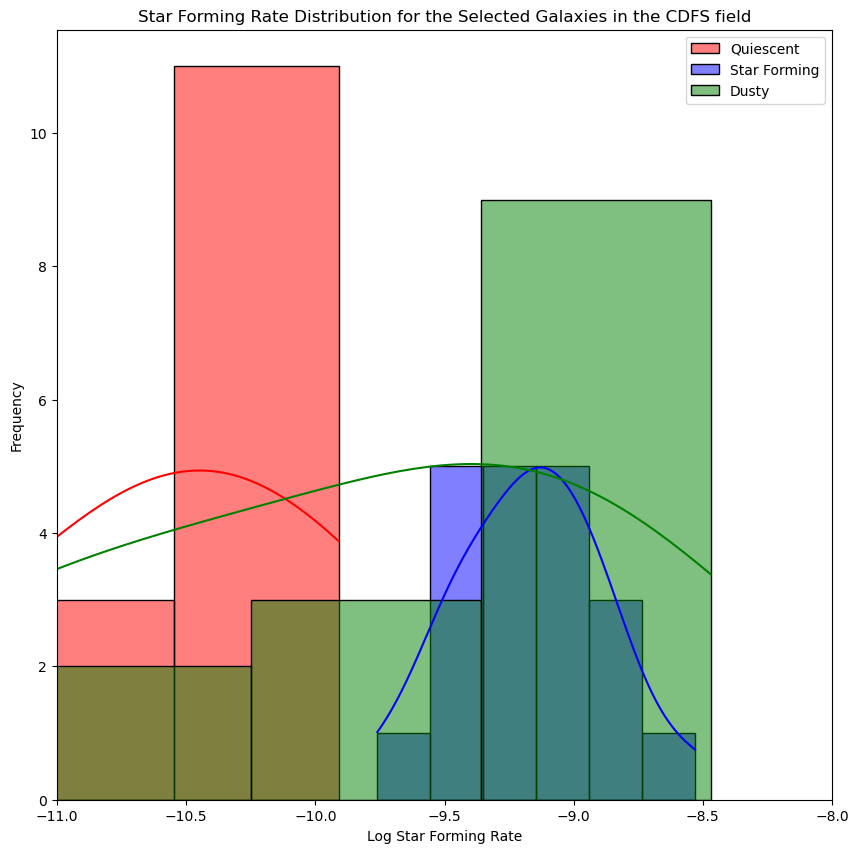

In [28]:
# Likewise we can also plot the star forming rate distribution for the selected galaxies, seperated by reigon
plt.figure(figsize=(10, 10))
sns.histplot(selected_df[selected_df['GalaxyType'] == 0]['lssfr'], kde=True
                , color='r', label='Quiescent')
sns.histplot(selected_df[selected_df['GalaxyType'] == 1]['lssfr'], kde=True
                , color='b', label='Star Forming')
sns.histplot(selected_df[selected_df['GalaxyType'] == 2]['lssfr'], kde=True
                , color='g', label='Dusty')
plt.xlabel('Log Star Forming Rate')
plt.ylabel('Frequency')

plt.xlim([-11, -8])

plt.title('Star Forming Rate Distribution for the Selected Galaxies in the CDFS field')
plt.legend()
plt.show()

# horrible looking plot, but it's functional

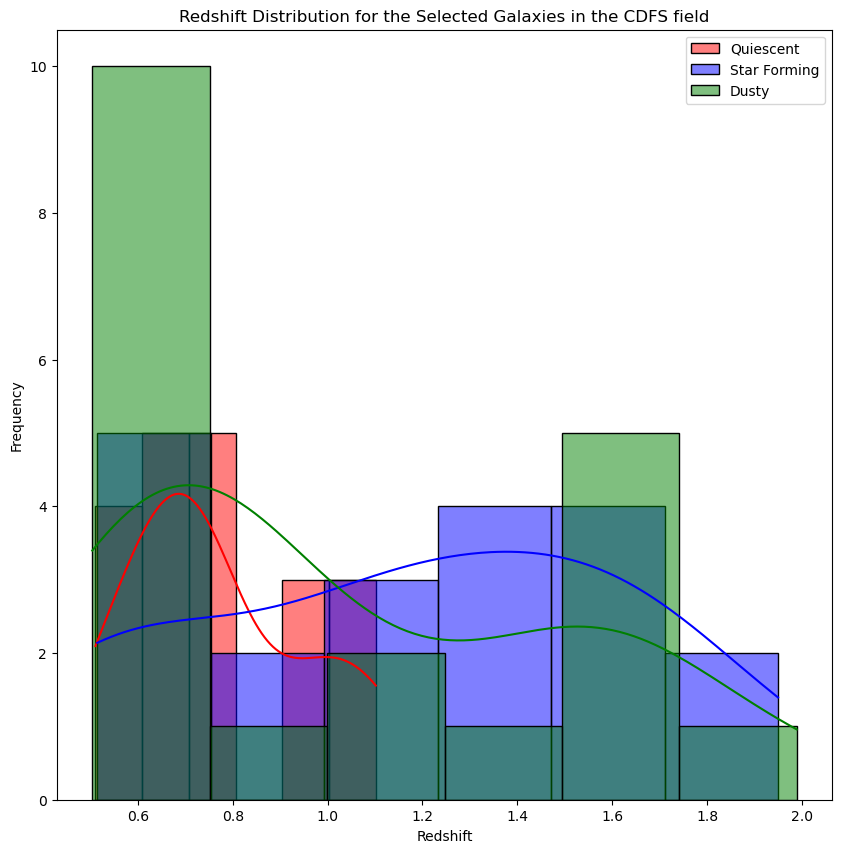

In [29]:
# Seperately we can also look at how the redshifts are distributed for the selected galaxies
plt.figure(figsize=(10, 10))
sns.histplot(selected_df[selected_df['GalaxyType'] == 0]['zpk'], kde=True
                , color='r', label='Quiescent')
sns.histplot(selected_df[selected_df['GalaxyType'] == 1]['zpk'], kde=True
                , color='b', label='Star Forming')
sns.histplot(selected_df[selected_df['GalaxyType'] == 2]['zpk'], kde=True
                , color='g', label='Dusty')
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('Redshift Distribution for the Selected Galaxies in the CDFS field')
plt.legend()
plt.show()


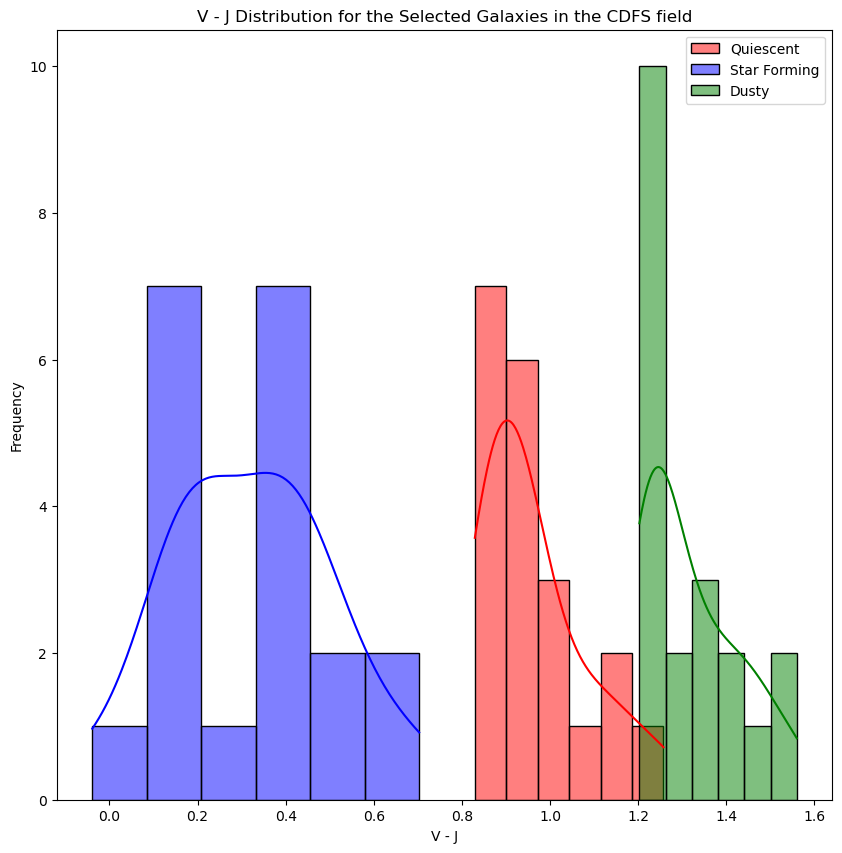

In [30]:
# And finally VJ histograms
plt.figure(figsize=(10, 10))
sns.histplot(selected_df[selected_df['GalaxyType'] == 0]['mag_V'] - selected_df[selected_df['GalaxyType'] == 0]['mag_J'], kde=True
                , color='r', label='Quiescent')
sns.histplot(selected_df[selected_df['GalaxyType'] == 1]['mag_V'] - selected_df[selected_df['GalaxyType'] == 1]['mag_J'], kde=True
                , color='b', label='Star Forming')
sns.histplot(selected_df[selected_df['GalaxyType'] == 2]['mag_V'] - selected_df[selected_df['GalaxyType'] == 2]['mag_J'], kde=True
                , color='g', label='Dusty')
plt.xlabel('V - J')
plt.ylabel('Frequency')
plt.title('V - J Distribution for the Selected Galaxies in the CDFS field')
plt.legend()
plt.show()


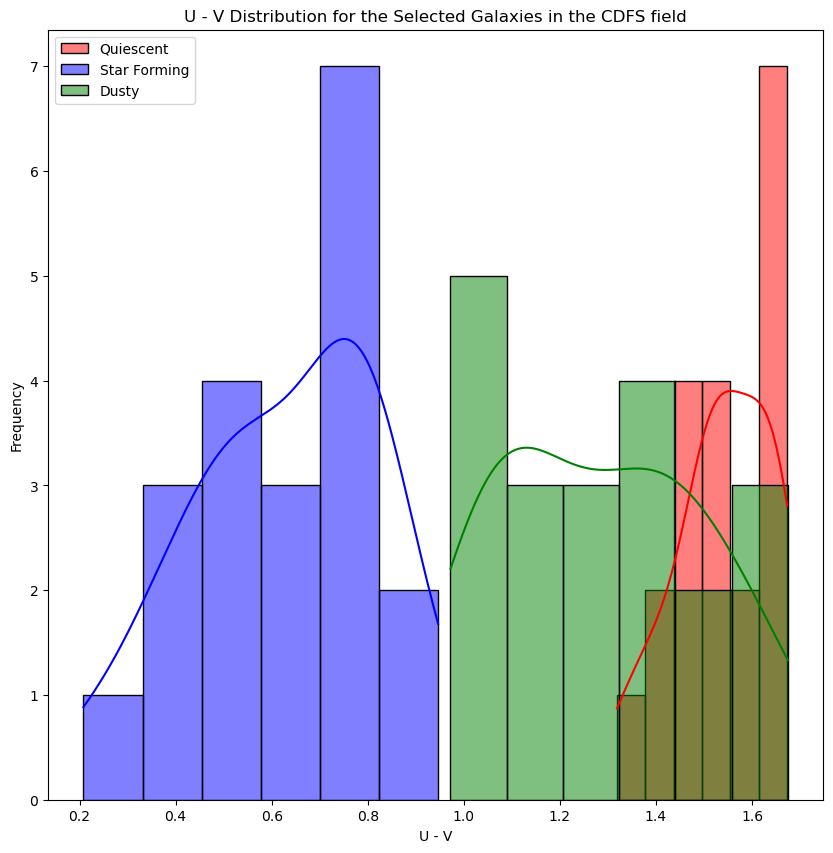

In [31]:
# and UV histrograms
plt.figure(figsize=(10, 10))
sns.histplot(selected_df[selected_df['GalaxyType'] == 0]['mag_U'] - selected_df[selected_df['GalaxyType'] == 0]['mag_V'], kde=True
                , color='r', label='Quiescent')
sns.histplot(selected_df[selected_df['GalaxyType'] == 1]['mag_U'] - selected_df[selected_df['GalaxyType'] == 1]['mag_V'], kde=True
                , color='b', label='Star Forming')
sns.histplot(selected_df[selected_df['GalaxyType'] == 2]['mag_U'] - selected_df[selected_df['GalaxyType'] == 2]['mag_V'], kde=True
                , color='g', label='Dusty')
plt.xlabel('U - V')
plt.ylabel('Frequency')
plt.title('U - V Distribution for the Selected Galaxies in the CDFS field')
plt.legend()
plt.show()


In [32]:
# As this script uses random number generation, we may need to save the data to a csv file for later use
# We can use the following function to save the data to a csv file with a unique name
def save_csv_with_numbered_name(df, save_path, file_name):
    # Check if the file already exists
    if os.path.isfile(os.path.join(save_path, f"{file_name}.csv")):
        # Append a number until a unique file name is found
        i = 1
        while os.path.isfile(os.path.join(save_path, f"{file_name}_{i}.csv")):
            i += 1
        file_name = f"{file_name}_{i}"
    
    # Save the DataFrame to CSV with the updated file name
    df.to_csv(os.path.join(save_path, f"{file_name}.csv"), index=False)
    print(f"CSV file saved as {file_name}.csv")

# We can also save this data to a csv file for later use
save_csv_with_numbered_name(selected_df, 'datasets/zfourge/GalaxySelectionOutputs', 'selected_uvj_data')

# Also saving the parameters used to generate the data
num_galaxies = num_galaxies_per_reigon


# Mass
mass_params = {'n_per_reigon': num_galaxies, 'sf_mass_limits': [starforming_lower, starforming_upper], 'qsct_mass_limits': [quiescent_lower, quiescent_upper], 'dust_mass_limits': [dusty_lower, dusty_upper]}

# calculated mean
mean_params = {'starforming_mean': starforming_mean, 'quiescent_mean': quiescent_mean, 'dusty_mean': dusty_mean}

# calculated std
std_params = {'starforming_std': starforming_std, 'quiescent_std': quiescent_std, 'dusty_std': dusty_std}

# sampling params
num_trials = 500
sample_size = 50
seed_num = seed
stat_params = {'num_trials': num_trials, 'sample_size': sample_size, 'seed' : seed_num}

# list of ID's selected
id_params = selected_ids
# Save all parameters to a single text file with numbered name
def save_all_params_with_numbered_name(params_dict, save_path, file_name):
    # Check if the file already exists
    if os.path.isfile(os.path.join(save_path, f"{file_name}.txt")):
        # Append a number until a unique file name is found
        i = 1
        while os.path.isfile(os.path.join(save_path, f"{file_name}_{i}.txt")):
            i += 1
        file_name = f"{file_name}_{i}"
    
    # Save all parameters to a single txt file with the updated file name
    with open(os.path.join(save_path, f"{file_name}.txt"), 'w') as file:
        for key, value in params_dict.items():
            file.write(f"{key}: {value}\n")
        print(f"All parameters saved as {file_name}.txt")

# Example parameters
all_params = {
    'mass_params': mass_params,
    'mean_params': mean_params,
    'std_params': std_params,
    'stat_params': stat_params,
    'id_params': id_params
    
}

# Save all parameters to a single text file with numbered name
save_all_params_with_numbered_name(all_params, 'datasets/zfourge/GalaxySelectionOutputs', 'selected_uvj_data_parameters')

CSV file saved as selected_uvj_data_1.csv
All parameters saved as selected_uvj_data_parameters_1.txt


In [33]:
# additionally we will also add the templates, but we need to export the 
# ids of the selected galaxies to a text file. These id's should be flattened in
# a single column

# in a second column have the associated redshift
# Save the selected IDs to a text file
# def save_ids_to_text(ids, save_path, file_name):
#     # Check if the file already exists
#     if os.path.isfile(os.path.join(save_path, f"{file_name}.txt")):
#         # Append a number until a unique file name is found
#         i = 1
#         while os.path.isfile(os.path.join(save_path, f"{file_name}_{i}.txt")):
#             i += 1
#         file_name = f"{file_name}_{i}"
    
#     # Save the IDs to a text file with the updated file name
#     with open(os.path.join(save_path, f"{file_name}.txt"), 'w') as file:
#         for id in ids.values.flatten():
#             #write the id in one column, and the redshift for the associated id in the next column
#             file.write(f"{id}\t{df['zpk'][df['id'] == id].values[0]}\n")
            
#         print(f"IDs saved as {file_name}.txt")
        
# # Save the selected IDs to a text file
# save_ids_to_text(selected_ids, 'datasets/zfourge', 'selected_uvj_data_ids')


    
selected_uvj_ids = selected_df['id']
selected_uvj_redshifts = selected_df['zpk']
selected_uvj_uv_pos = selected_df['mag_U'] - selected_df['mag_V']
selected_uvj_vj_pos = selected_df['mag_V'] - selected_df['mag_J']


# combine these into a single dataframe
selected_uvj_df_ids = pd.DataFrame({'id': selected_uvj_ids, 'zpk': selected_uvj_redshifts, 'uv' : selected_uvj_uv_pos, 'vj' : selected_uvj_vj_pos})


# save the selection to a csv file
save_csv_with_numbered_name(selected_uvj_df_ids, 'datasets/zfourge/GalaxySelectionOutputs', 'selected_uvj_data_ids')


CSV file saved as selected_uvj_data_ids_1.csv
